<a href="https://colab.research.google.com/github/YogeshMaan/MAE598-Design-Optimization/blob/main/HW4_DesignOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initialize parameters
1. $x_{0}$
2. $λ_{0}$
3. $μ_{0}$
4. $W_{0}$ (initialized as an identity matrix)
5. $k=0$ (counter for iterations)
6. $ϵ=10e-3$



In [144]:
#import dependencies
import numpy as np
import cvxopt
import cvxopt.solvers

### Calculate the lagrangian derivative
$$∇_{x}L = ∇_{x}f + λ^{T}∇_{x}h + μ^{T}∇_{x}g  $$

In [145]:
def objective(x):
  return np.array([[x[0][0]**2 + (x[1][0]-3)**2]]).astype('float')

In [146]:
def objectiveg(x):
  return np.array([[2*x[0][0], 2*x[1][0]-6]]).astype('float')

In [147]:
def constraint(x):
  return np.array([[x[1][0]**2-2*x[0][0]],
                    [x[1][0]**2]+5*x[0][0]-15]).astype('float')

In [148]:
def constraintg(x):
  return np.array([[-2, 2*x[1][0]], [5, 2*x[1][0]-2]]).astype('float')


In [149]:
# P: Hessian matrix
# q: gradient of objective
# G: gradient of constraints
# h: -constraint(x)

# GET
# s = sol['x']
# mu_new = sol['z']

def solve_qp_subproblem(P, q, G, h, A=None, b=None):
    """
    Solve a Quadratic Programming subproblem using cvxopt.

    Parameters:
    - P: Symmetric matrix representing the quadratic cost
    - q: Vector representing the linear cost
    - G: Matrix defining the inequality constraints (optional)
    - h: Vector defining the inequality constraints (optional)
    - A: Matrix defining the equality constraints (optional)
    - b: Vector defining the equality constraints (optional)

    Returns:
    - sol: Solution to the QP problem
    """
    # Convert parameters to cvxopt matrices
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)

    if G is not None:
        G = cvxopt.matrix(G)
        h = cvxopt.matrix(h)
    else:
        G = cvxopt.matrix(0.0, (0, P.size[0]))
        h = cvxopt.matrix(0.0, (0, 1))

    if A is not None:
        A = cvxopt.matrix(A)
        b = cvxopt.matrix(b)
    else:
        A = cvxopt.matrix(0.0, (0, P.size[0]))
        b = cvxopt.matrix(0.0, (0, 1))

    # Solve the QP problem
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)

    return sol


In [150]:
def lineSearch(x, s, mu_old, w_old):
  t = .1
  b = .8
  a = 1

  D = s

  #calculate weights in the merit function
  w = np.maximum(np.abs(mu_old), 0.5*(w_old + np.abs(mu_old)))
  count = 0
  #terminate if lineSearch takes too long
  while count<100:
    phi_a = objective(x + a*D) +np.matmul(w.T, np.abs(np.minimum(0, -constraint(x + a*D))))

    #calculate psi
    phi0 = objective(x) + np.matmul(w.T, np.abs(np.minimum(0, -constraint(x))))
    dphi0 = np.matmul(objectiveg(x), D) + np.matmul(w.T, np.multiply(np.matmul(constraintg(x), D), constraint(x)>0) )
    psi_a = phi0 + t*a*dphi0

    if phi_a<psi_a:
      break
    else:
      a = a*b
      count = count+1

  return a, w


In [151]:
def mysqp(x0, eps):
  # set initial conditions
  x = x0
  # initialize an empty array to store current solution
  solution = []

  #initialization of the hessian matrix
  W = np.eye(x.shape[0], x.shape[0])

  #initialization of the lagrangian multipliers
  mu_old = np.zeros(constraint(x).shape)
  w = np.zeros(constraint(x).shape)

  #set the termination criterion
  gnorm = np.linalg.norm(objectiveg(x) + np.matmul(mu_old.T, constraintg(x)))

  while gnorm>eps:

  # solve qpsubproblem to find s and mu (using cvxopt.solvers)
    sol = solve_qp_subproblem(W, objectiveg(x).T, constraintg(x), -constraint(x))
    s = sol['x']
    mu_new = sol['z']

  # insert lineSearch here for a = .01
    a, w = lineSearch(x, s, mu_old, w)

    #update the current solution using the step
    dx = a*s
    x = x+dx

    #update hessian using BFGS
    y_k = objectiveg(x) + np.matmul(mu_new.T, constraintg(x)) - objectiveg(x-dx) - np.matmul(mu_new.T, constraintg(x-dx))
    y_k = y_k.T

    if np.matmul(dx.T, y_k) >= 0.2*np.matmul(np.matmul(dx.T, W), dx):
      theta = 1
    else:
      theta = 0.8*np.matmul(np.matmul(dx.T, W), dx)/(np.matmul(np.matmul(dx.T, W), dx) - np.matmul(dx.T, y_k))

    # compute dg_k
    dg_k = theta*y_k + (1-theta)*np.matmul(W, dx) # check theta shape

    #compute new hessian

    W = W + (np.matmul(dg_k, dg_k.T)/np.matmul(dg_k.T, dx)) - (np.matmul(np.matmul(W, dx), np.matmul(W, dx).T)/np.matmul(np.matmul(dx.T, W), dx))

    #update termination criterion
    gnorm = np.linalg.norm(objectiveg(x) + np.matmul(mu_new.T, constraintg(x)))
    mu_old = mu_new
    solution.append(x)

  return solution


In [152]:
# initialized parameters
x0 = np.array([[4],[3]]) #its a feasible point for HW problem
eps = 10e-3

solution = mysqp(x0, eps)

## Solution to the Problem

In [153]:
print(solution[4])

[[1.0583139 ]
 [1.45613446]]


## Ploting the solution

In [154]:
import matplotlib.pyplot as plt


In [155]:
x = []
y = []
for i in range(len(solution)):
  x.append(solution[i][0][0])
  y.append(solution[i][1][0])

Text(0.5, 1.0, 'solution convergence')

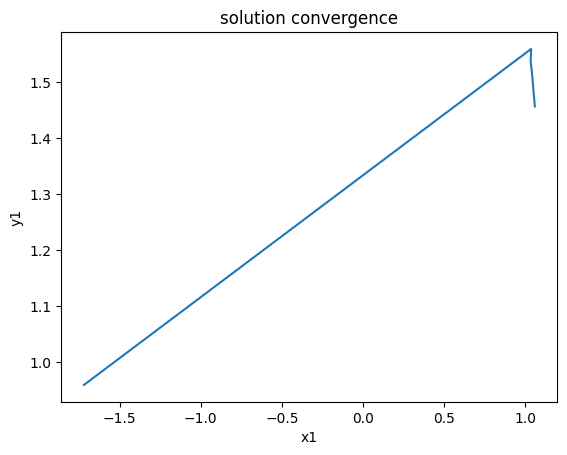

In [156]:
plt.plot(x, y)
plt.xlabel('x1')
plt.ylabel('y1')
plt.title('solution convergence')